In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import cdist
import math

configuration = tflscripts.read_configuration()

In [177]:
HIGH_SAMPLING_EUCLIDEAN_DISTANCE_THRESHOLD = 200.0
HIGH_SAMPLING_EUCLIDEAN_DISTANCE_HYSTERESIS_THRESHOLD = 150.0

LOW_SAMPLING_ZSCORE_THRESHOLD = 3.5
LOW_SAMPLING_ZSCORE_HYSTERESIS_THRESHOLD = 3.0

SENSOR_BUFFER_HISTORY_SIZE = 5
BG_BUFFER_HISTORY_LENGTH = 1000

LOW_SAMPLING_RANGES = { # [min, max, stdev]
    'ACCEL': [0.0, 0.0, 20], # was 0.001
    'MICROPHONE': [0.0, 0.0, 1], # was 0.001
    'EMI': [0.0, 0.0, 1.5], # was 0.001
    'TEMPERATURE': [0.0, 120.0, 1.5],
    'BAROMETER': [870.0, 1013.0, 1.2],
    'HUMIDITY': [0.0, 100.0, 10.0],
    'ILLUMINATION': [0.0, 4096.0, 50.0],
    'COLOR': [0.0, 255.0, 10.0],
    'MAGNETOMETER': [-30.0, 30.0, 5.0],
    'WIFI': [-70.0, 0.0, 1], # was 0.2
    'IRMOTION': [0.0, 4096.0, 30.0],
    'GEYE': [0.0, 128.0, 10.0]
}


class ChannelAnomalyComputer:

    def __init__(self, columns):
        self.columns = columns
        self.is_hysteresis = False
        self.channel = columns[0].split('_')[0]
        self.is_fft = '_fft' in columns[0]
        self.background_history = []

        if not self.is_fft:
            mean_columns = [i for i, col in enumerate(columns) if '_avg' in col]
            self.mean_column = mean_columns[0]

    def add_history(self, history):
        if len(history) <= BG_BUFFER_HISTORY_LENGTH:
            self.background_history = history
        else:
            idx = np.random.choice(len(history), BG_BUFFER_HISTORY_LENGTH)
            self.background_history = history[idx]

        self.history_mean = np.mean(self.background_history, axis=0)
        self.history_stdev = np.std(self.background_history, axis=0)

    def is_anomaly(self, target_history):
        dist = self.get_distance(target_history)
        threshold = self.get_threshold()
#         if self.channel == 'ACCEL':
#             threshold *= 0.2
        if self.channel == 'MICROPHONE':
            threshold *= 0.2

        anomaly = dist > threshold
        self.is_hysteresis = anomaly
        return anomaly

    def get_threshold(self):
        if self.is_fft:
            if self.is_hysteresis:
                return HIGH_SAMPLING_EUCLIDEAN_DISTANCE_HYSTERESIS_THRESHOLD
            else:
                return HIGH_SAMPLING_EUCLIDEAN_DISTANCE_THRESHOLD
        else:
            if self.is_hysteresis:
                return LOW_SAMPLING_ZSCORE_HYSTERESIS_THRESHOLD
            else:
                return LOW_SAMPLING_ZSCORE_THRESHOLD

    def get_distance(self, target_history):
        if self.is_fft:
            target_mean = np.mean(target_history, axis=0)

            zscore = (target_mean - self.history_mean) / self.history_stdev
            zscore[zscore == np.inf] = 0
            zscore[zscore == -np.inf] = 0

            zscore = np.nan_to_num(zscore)
            dist = np.sqrt(zscore * zscore).sum()
            return dist

        else:
            mn, mx, stdev = LOW_SAMPLING_RANGES[self.channel]
            target_mean = np.mean(target_history, axis=0)[self.mean_column]
            history_mean = self.history_mean[self.mean_column]
            zscore = np.abs(target_mean - history_mean) / stdev
            return np.nan_to_num(zscore)


def activation_groups(df, sensor_channels):
    channel_columns = [df.filter(regex=chan).columns.tolist() for chan in sensor_channels]
    channel_anomaly_computers = [ChannelAnomalyComputer(columns) for columns in channel_columns]

    null_df = df.loc[df.label == configuration['activities'].index('Null')]
    anomalies = []

    for computer in channel_anomaly_computers:
        computer.add_history(null_df[computer.columns].values)

        channel_df = df[computer.columns]

        history = []
        channel_anomalies = []
        for row in channel_df.values:
            history.append(row)
            if len(history) > SENSOR_BUFFER_HISTORY_SIZE:
                history.pop(0)

            anomaly = computer.is_anomaly(history)
            channel_anomalies.append([anomaly])
        anomalies.append(channel_anomalies)

    anomalies = np.concatenate(anomalies, axis=1)
    anomalies = pd.DataFrame(anomalies)
    anomalies.columns = sensor_channels
    anomalies.index = df.index

    return anomalies

In [182]:
device = '128.237.248.186'
dataset = 'scott-final-iter1'

sensor_channels = [
    'MICROPHONE_fft',
    'MICROPHONE_sst',
    'ACCEL_fft_0',
    'ACCEL_sst_0',
    'ACCEL_fft_1',
    'ACCEL_sst_1',
    'ACCEL_fft_2',
    'ACCEL_sst_2',
    'EMI',
    'MAGNETOMETER',
    'GEYE',
    'COLOR',
    'TEMPERATURE',
    'IRMOTION',
    'WIFI_RSSI',
    'HUMIDITY',
    'BAROMETER'
]

dataset_path = '../datasets/' + dataset + '-complete/'
df = pd.read_pickle(dataset_path + device + '.p')

anomalies = activation_groups(df, sensor_channels)

/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide


In [183]:
anomalies[anomalies == False] = 0
anomalies[anomalies == True] = 1
labels = [configuration['activities'][int(i)] for i in df.label]
anomalies['label'] = labels

1

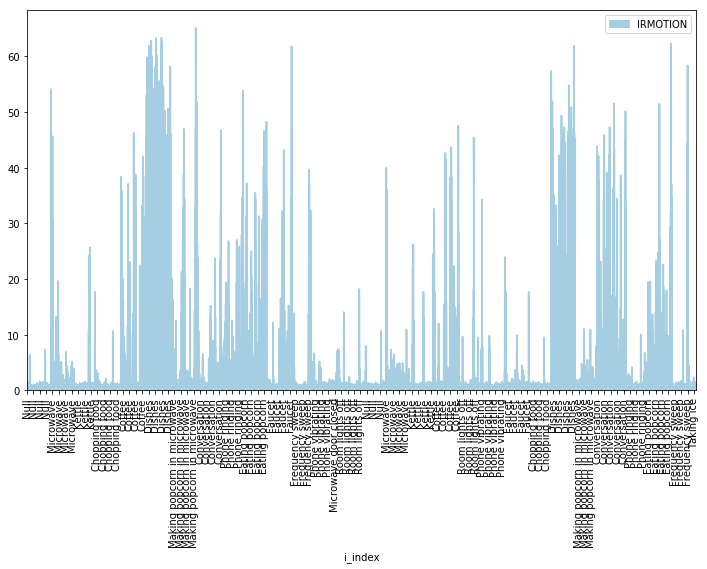

In [119]:
anomalies[['IRMOTION']].plot.area(stacked=True, colormap='Paired')
labels = [configuration['activities'][int(i)] for i in df.label]
plt.xticks(np.arange(0.5, len(labels), 500), labels[::500], rotation='vertical')
1

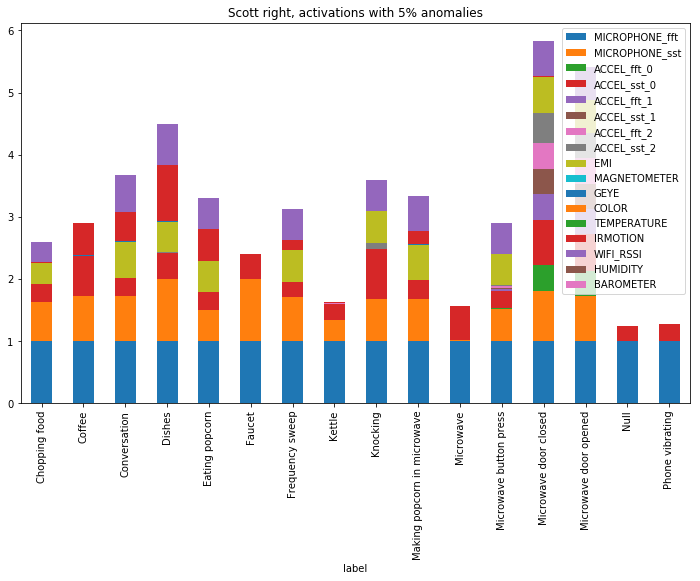

In [184]:
anomalies.groupby('label').mean().plot.bar(stacked=True)
plt.title('Scott right, activations with 5% anomalies')

In [13]:
def read_dataset_by_activation_groups(dataset, device, activities, complete_df):
    anomaly_percentile = 50

    sensor_channels_percentiles = {
        'MICROPHONE_fft': 50,
#         'MICROPHONE_sst': 10,
        'ACCEL_fft': 10,
#         'ACCEL_sst': 10,
#         'EMI': 10,
#         'MAGNETO': 10,
#         'GEYE': 10,
#         'COLOR': 10,
#         'TEMPERATURE': 10,
#         'IRMOTION': 10,
#         'RSSI': 10,
#         'HUMIDITY': 10,
#         'BAROMETER': 10
    }
    sensor_channels = np.sort([c for c in sensor_channels_percentiles])

    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')

#     null_df = df.loc[df.label == configuration['activities'].index('Null')]

    activities_i = [configuration['activities'].index(a) for a in activities]
    df = df.loc[df.label.isin(activities_i)]

    value_columns = df.filter(regex='|'.join(sensor_channels)).columns
    mean = complete_df[value_columns].mean()
    std = complete_df[value_columns].std()
    df[value_columns] = (df[value_columns] - mean) / std
    df = df.replace([np.inf, -np.inf], np.nan)

    anomalies_df = {}

    for channel in sensor_channels:
        value_columns = df.filter(regex=channel).columns

        anomalies = (df[value_columns] ** 2).sum(axis=1).apply(np.sqrt)
        anomalies_df[channel] = anomalies

    anomalies_df = pd.DataFrame(anomalies_df)
    anomalies_df = anomalies_df.sort_index(axis=1)

    for column in anomalies_df.columns:
        percentile = sensor_channels_percentiles[column]
        threshold = np.percentile(anomalies_df[column].values, 100 - percentile)
        anomalies_df[column] = [x > threshold for x in anomalies_df[column]]

    anomalies_df['signature'] = [';'.join([str(x) for x in row]) for row in anomalies_df.values]

    datasets_by_signature = {}

    for signature in anomalies_df['signature'].unique():
        column_presence = [presence == 'True' for presence in signature.split(';')]
        columns = [col for i, col in enumerate(sensor_channels) if column_presence[i]]
        if len(columns) == 0:
            continue

        subdf = df.loc[anomalies_df.signature == signature]
        y = subdf.label
        x = subdf.filter(regex='|'.join(columns))

        if len(y) > 0:
            datasets_by_signature[signature] = [x, y]

    return datasets_by_signature

In [14]:
class CustomPipeline:
    def __init__(self, steps):
        self.steps = steps
        self.single_class = None

    def fit(self, x, y):
        if len(np.unique(y)) > 1:
            self.ppl = Pipeline(self.steps)
            self.ppl.fit(x, y)
        else:
            self.single_class = np.unique(y)[0]

    def predict(self, x):
        if self.single_class is not None:
            return [self.single_class for _ in np.array(x)]
        else:
            return self.ppl.predict(x)

activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]
    
anomaly_percentile = 50

# source_device = '128.237.254.195'
# source_dataset = 'synergy-final-iter1'
target_device = '128.237.248.186'
target_dataset = 'synergy-final-iter2'
# source_device = '128.237.248.186'
# source_dataset = 'scott-final-iter1'
# target_device = '128.237.246.127'
# target_dataset = 'scott-final-iter1'

sources = [
#     ['128.237.248.186', 'scott-final-iter1'],
#     ['128.237.248.186', 'synergy-final-iter2'],
#     ['128.237.246.127', 'robotics-final'],
    ['128.237.254.195', 'synergy-final-iter1']
]

source_datasets_by_signature = {}
for source in sources:
    datasets = read_dataset_by_activation_groups(dataset=source[1],
                                                 device=source[0],
                                                 complete_df=complete_df,
                                                 activities=activities)
    
    for signature in datasets:
        if signature in source_datasets_by_signature:
            source_datasets_by_signature[signature] = [
                pd.concat([source_datasets_by_signature[signature][0], datasets[signature][0]]),
                pd.concat([source_datasets_by_signature[signature][1], datasets[signature][1]]),
            ]
        else:
            source_datasets_by_signature[signature] = datasets[signature]

target_datasets_by_signature = read_dataset_by_activation_groups(dataset=target_dataset,
                                                                 device=target_device,
                                                                 complete_df=complete_df,
                                                                 activities=activities)

pipelines = {}

for signature in source_datasets_by_signature:
    ppl = CustomPipeline([
        ('impute', Imputer()),
        ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
    ])
    x, y = source_datasets_by_signature[signature]
    ppl.fit(x, y)

    pipelines[signature] = ppl

dfs_y = []

for signature in target_datasets_by_signature:
    x, y = target_datasets_by_signature[signature]

    if signature in pipelines:
        ppl = pipelines[signature]
        predicted = ppl.predict(x)

        df_y = pd.DataFrame(y)
        df_y['predicted'] = predicted
        dfs_y.append(df_y)
        print(accuracy_score(y, predicted))

df_y = pd.concat(dfs_y, axis=0)
print('Final', accuracy_score(df_y.label, df_y.predicted))

0.585795824001
0.504373177843
0.098144823459
Final 0.53091684435


In [28]:
x_train, y_train = get_dataset_and_filter_outliers('128.237.254.195', 'synergy-final-iter1')
x_test, y_test = get_dataset_and_filter_outliers('128.237.248.186', 'synergy-final-iter2')

ppl = Pipeline([
    ('impute', Imputer()),
#     ('clf', OneVsRestClassifier(RandomForestClassifier()))
    ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
#     ('clf', LogisticRegression())
])

ppl.fit(x_train, y_train)

predicted = ppl.predict(x_test)
accuracy_score(y_test, predicted)

0.238625

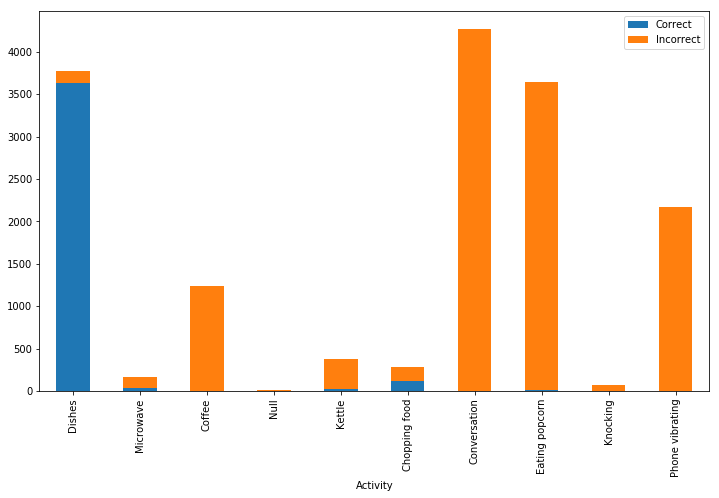

In [29]:
results = []
configuration = tflscripts.read_configuration()
for i in np.unique(y_test):
    activity = configuration['activities'][int(i)]
    correct = len([x for x in predicted[y_test == i] if x == i])
    incorrect = len([x for x in predicted[y_test == i] if x != i])
    results.append([activity, correct, incorrect])
results = pd.DataFrame(results)
results.columns = ['Activity', 'Correct', 'Incorrect']
results = results.set_index('Activity')
results.plot.bar(stacked=True)

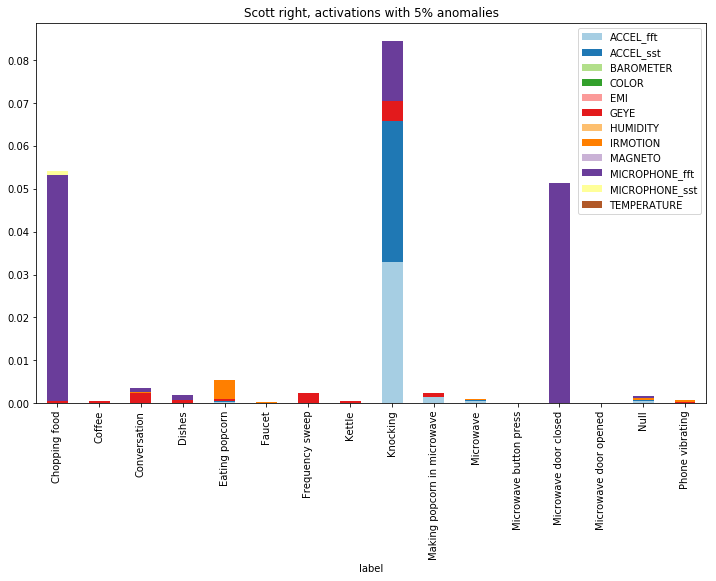

In [11]:
device = '128.237.246.127'
dataset = 'robotics-final'

activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Null",
    "Faucet",
    "Kettle",
    "Phone ringing",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Microwave door opened",
    "Microwave door closed",
    "Cupboard door opened",
    "Cupboard door closed",
    "Microwave button press",
    "Taking ice",
    "Making popcorn in microwave",
    "Room lights off",
    "Knocking",
    "Frequency sweep",
    "Phone vibrating"
]

percentile = 200
sensor_channels_percentiles = {
    'MICROPHONE_fft': percentile,
    'MICROPHONE_sst': percentile,
    'ACCEL_fft': percentile,
    'ACCEL_sst': percentile,
    'EMI': percentile,
    'MAGNETO': percentile,
    'GEYE': percentile,
    'COLOR': percentile,
    'TEMPERATURE': percentile,
    'IRMOTION': percentile,
#     'RSSI': 10,
    'HUMIDITY': percentile,
    'BAROMETER': percentile
}
sensor_channels = np.sort([c for c in sensor_channels_percentiles])

dataset_path = '../datasets/' + dataset + '-complete/'
df = pd.read_pickle(dataset_path + device + '.p')
value_columns = df.filter(regex='|'.join(sensor_channels)).columns

df[value_columns] = average_values(df[value_columns])

activities_i = [configuration['activities'].index(a) for a in activities]
df = df.loc[df.label.isin(activities_i)]

anomalies_df = {}

for channel in sensor_channels:
    value_columns = df.filter(regex=channel).columns

    anomalies = (df[value_columns] ** 2).sum(axis=1).apply(np.sqrt)
    anomalies_df[channel] = anomalies

anomalies_df = pd.DataFrame(anomalies_df)
anomalies_df = anomalies_df.sort_index(axis=1)

for column in anomalies_df.columns:
#     percentile = sensor_channels_percentiles[column]
#     threshold = np.percentile(anomalies_df[column].values, 100 - percentile)
    threshold = sensor_channels_percentiles[column]
    anomalies_df[column] = [1 if x > threshold else 0 for x in anomalies_df[column]]

labels = [configuration['activities'][int(i)] for i in df.label]
anomalies_df['label'] = labels

anomalies_df.groupby('label').mean().plot.bar(stacked=True, colormap='Paired')
plt.title('Scott right, activations with 5% anomalies')